# Create Gaussian Random Fields for Heat Diffusion
In this notebook we use the FyeldGenerator package to create datasets of Gaussian random fields.

#### Setup FyeldGenerator

In [11]:
import os

from FyeldGenerator import generate_field

HEIGHT = 256
WIDTH = HEIGHT
shape = (HEIGHT, WIDTH)

# path to save the data 
DATA_ROOT = os.path.abspath('github/smdp/heat-diffusion/data/files')

Define function to generate power-law power spectrum and generate a sample field 

In [2]:
import numpy as np

# Helper that generates power-law power spectrum
def Pkgen(n):
    def Pk(k):
        return np.power(k, -n)

    return Pk

# Draw samples from a normal distribution
def distrib(shape):
    a = np.random.normal(loc=0, scale=1, size=shape)
    b = np.random.normal(loc=0, scale=1, size=shape)
    return a + 1j * b

np.random.seed(0)
field = generate_field(distrib, Pkgen(4), shape)

Plot the generated field

/tmp/ipykernel_271338/3108680694.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


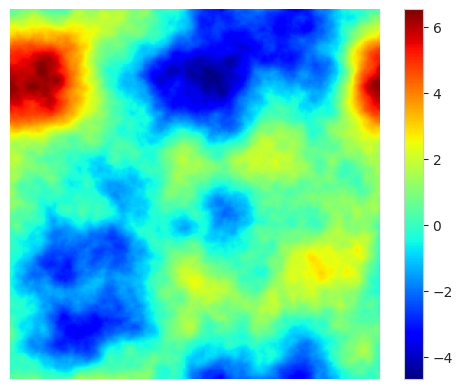

In [3]:
import matplotlib.pyplot as plt

plt.imshow(field, cmap='jet')
plt.axis('off')
plt.colorbar()
plt.show()

Define a function that stores the fields as a dataset

In [4]:
import h5py
from pathlib import Path
import os
from PIL import Image

cmap = plt.get_cmap('jet')

def generate_dataset(pw_exponent, num_samples, dataset_name, seed, shape=shape):
    
    np.random.seed(seed)
    
    powerlaw = Pkgen(pw_exponent)
    
    data_h5 = h5py.File(f'{DATA_ROOT}/{dataset_name}.h5', 'w')
    
    Path(os.path.join(DATA_ROOT, dataset_name)).mkdir(exist_ok=True)
    
    for n in range(num_samples):
        field = generate_field(distrib, powerlaw, shape)
        field_normalized = (field - np.min(field)) / (np.max(field) - np.min(field))
        im = np.uint8(cmap(field_normalized) * 255)
        im = Image.fromarray(im)
        
        im.save(f'{DATA_ROOT}/{dataset_name}/{n:05d}.png')
        
        data_h5.create_dataset(f'{n:05d}', data=field)
        

### Generate and save datasets for different resolutions
Save train dataset (2500 samples), validation dataset (500 samples) and test dataset (500 samples) for each resolution.

#### 32 x 32

In [5]:
shape_32 = (32, 32) 
Path(os.path.join(DATA_ROOT, '32')).mkdir(exist_ok=True)    
generate_dataset(4, 2500, '32/2d_gaussian_random_field_4', hash('2d_gaussian_random_field_4') % (2**32 - 1), shape=shape_32)
generate_dataset(4, 500, '32/2d_gaussian_random_field_4_val', hash('2d_gaussian_random_field_4_val') % (2**32 - 1), shape=shape_32)
generate_dataset(4, 500, '32/2d_gaussian_random_field_4_test', hash('2d_gaussian_random_field_4_test') % (2**32 - 1), shape=shape_32)

#### 64 x 64

In [27]:
shape_64 = (64, 64)
generate_dataset(4, 2500, '64/2d_gaussian_random_field_4', hash('2d_gaussian_random_field_4') % (2**32 - 1), shape=shape_64)
generate_dataset(4, 500, '64/2d_gaussian_random_field_4_val', hash('2d_gaussian_random_field_4_val') % (2**32 - 1), shape=shape_64)
generate_dataset(4, 500, '64/2d_gaussian_random_field_4_test', hash('2d_gaussian_random_field_4_test') % (2**32 - 1), shape=shape_64)

<ipython-input-12-d90b68957aeb>:4: RuntimeWarning: divide by zero encountered in power
  return np.power(k, -n)


#### 128 x 128

In [28]:
shape_128 = (128, 128)
generate_dataset(4, 2500, '128/2d_gaussian_random_field_4', hash('2d_gaussian_random_field_4') % (2**32 - 1), shape=shape_128)
generate_dataset(4, 500, '128/2d_gaussian_random_field_4_val', hash('2d_gaussian_random_field_4_val') % (2**32 - 1), shape=shape_128)
generate_dataset(4, 500, '128/2d_gaussian_random_field_4_test', hash('2d_gaussian_random_field_4_test') % (2**32 - 1), shape=shape_128)

<ipython-input-12-d90b68957aeb>:4: RuntimeWarning: divide by zero encountered in power
  return np.power(k, -n)


## Open .h5 file and check if the data is correct   

Import DataLoader to load .h5 file

In [12]:
import sys
sys.path.append(os.path.join(os.path.abspath(''), 'github', 'smdp', 'heat-diffusion'))

from dataloader import DataLoader

In [13]:
dataset_name = '32/2d_gaussian_random_field_4'

params = {'file': f'{DATA_ROOT}/{dataset_name}.h5', 'batch_size': 32}

with h5py.File(params['file'], 'r') as f:
    train_keys = list(f.keys())
    train_keys = list(zip([params['file']] * len(train_keys), train_keys))
    
train_generator = DataLoader([params['file']], train_keys, params['batch_size'], name='train')

Length: 2500


Normalize the data

In [15]:
mean, std, min_, max_ = train_generator.get_norm()
train_generator.set_mean_and_std(mean, std)

Plot the batch of samples   

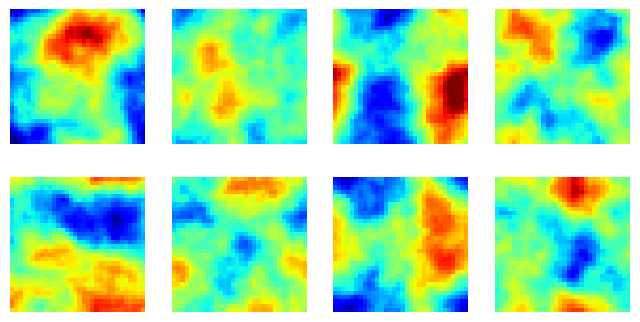

In [18]:
fig, axes = plt.subplots(2, 4, figsize=(8, 4))

samples = train_generator.__getitem__(0)

vmax = np.max(samples[0])
vmin = np.min(samples[0])

for i in range(2):
    for j in range(4):
        im = axes[i, j].imshow(samples[i * 8 + j, :, :, 0], cmap='jet', vmin=vmin, vmax=vmax)
        axes[i, j].axis('off')